In [1]:
import pandas as pd
import panel as pn
import numpy as np
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set

pn.extension('tabulator')

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()
engine = create_engine("sqlite:///c:\\ruby\\portmy\\db\\development.sqlite3")
conmy = engine.connect()

data_path = "../data/"
csv_path = "\\Users\\User\\iCloudDrive\\"
box_path = "\\Users\\User\\Dropbox\\"
one_path = "\\Users\\User\\OneDrive\\Documents\\Data\\"

today = date.today()
today

datetime.date(2022, 3, 4)

### Set today = last closed business day

In [2]:
#today = today - timedelta(days=3)
today

datetime.date(2022, 3, 4)

### Restart and Run All Cells

In [3]:
sqlUpd = """
UPDATE buy B
SET dividend =
(SELECT DIVIDEND FROM dividend D
WHERE B.name = D.name)"""
rp = const.execute(sqlUpd)
rp.rowcount

27

In [4]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()

In [5]:
format_dict = {
    'shares':'{:,}','div_rnk':'{:,}','amt_rnk':'{:,}',  
    'price':'{:.2f}','unit_cost':'{:.2f}','mkt_price':'{:.2f}',
    'cost_amt':'{:,.2f}','div_amt':'{:,.2f}','mkt_amt':'{:,.2f}',
    'profit':'{:,.2f}','base_amt':'{:,.2f}','cumsum':'{:,.2f}',
    'dividend':'{:.4f}',    
    'pct':'{:,.2f}%','cost_pct':'{:,.2f}%','mkt_pct':'{:,.2f}%','pft_pct':'{:,.2f}%',
}

### Change period of stock in table buy

In [6]:
name = 'SIS'
sql = """
SELECT * 
FROM buy 
WHERE name = '%s' 
"""
sql = sql % name
df = pd.read_sql(sql, const)
df

,name,date,volbuy,price,volsell,volbal,active,dividend,period,grade
0,SIS,2021-05-14,4500.0,40.5,0.0,0.0,1,1.2,4,A1


In [7]:
grade = 'A1'
period = '4'
sqlUpd = """
UPDATE buy
SET period = '%s', grade = '%s'
WHERE name = '%s' 
"""
sqlUpd = sqlUpd % (period, grade, name)
print(sqlUpd)


UPDATE buy
SET period = '4', grade = 'A1'
WHERE name = 'SIS' 



In [8]:
rp = const.execute(sqlUpd)
rp.rowcount

1

### Discrepancies calculation

In [9]:
sql = '''
SELECT *
FROM buy
WHERE active = 1'''
df = pd.read_sql(sql, const)
df.drop(['volsell', 'volbal'], axis=1, inplace=True)
df.rename(columns={'volbuy': 'shares','price':'unit_cost'}, inplace=True)
df['shares'] = df['shares'].astype('int64')
df['cost_amt'] = df.shares * df.unit_cost
df.shape

(27, 9)

In [10]:
sql = '''
SELECT name, market
FROM stocks
ORDER BY name'''
my_stocks = pd.read_sql(sql, conmy)
my_stocks.shape

(359, 2)

In [11]:
filters = [
   (my_stocks.market.str.contains('SET50')),
   (my_stocks.market.str.contains('SET100')),
   (my_stocks.market.str.contains('mai'))    
]
values = [450000.0,300000.0,150000.0]

In [12]:
my_stocks["base_amt"] = np.select(filters, values, default=150000)
my_stocks.head().style.format(format_dict)

,name,market,base_amt
0,2S,SET,"150,000.00"
1,AAV,sSET / SETTHSI,"150,000.00"
2,ACE,SET100,"300,000.00"
3,ADVANC,SET50 / SETHD / SETTHSI,"450,000.00"
4,AEONTS,SET100,"300,000.00"


In [13]:
df_merge = pd.merge(df, my_stocks, on='name', how='inner')
df_merge.shape

(27, 11)

In [14]:
df_merge['pct'] = round(df_merge.cost_amt/df_merge.base_amt*100,2)
mask = df.period != '2'
df_merge[mask][cols].head().style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
0,STA,1,"22,500",33.75,"759,375.00","300,000.00",253.12%
2,KCE,1,"11,000",75.50,"830,500.00","450,000.00",184.56%
6,MAKRO,3,"3,000",42.00,"126,000.00","150,000.00",84.00%
7,WHART,4,"10,000",12.50,"125,000.00","150,000.00",83.33%
8,BCH,3,"15,000",21.30,"319,500.00","300,000.00",106.50%


In [15]:
df_merge[mask].nlargest(5, 'pct')[cols].style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
0,STA,1,"22,500",33.75,"759,375.00","300,000.00",253.12%
2,KCE,1,"11,000",75.50,"830,500.00","450,000.00",184.56%
13,PTTGC,1,"12,000",58.75,"705,000.00","450,000.00",156.67%
22,SYNEX,3,"15,000",29.50,"442,500.00","300,000.00",147.50%
24,RCL,3,"9,000",46.25,"416,250.00","300,000.00",138.75%


In [16]:
df_merge[mask].nsmallest(5, 'pct')[cols].style.format(format_dict)

,name,period,shares,unit_cost,cost_amt,base_amt,pct
9,SINGER,3,"4,500",42.25,"190,125.00","300,000.00",63.38%
20,MEGA,3,"4,500",43.00,"193,500.00","300,000.00",64.50%
16,SPALI,3,"9,000",22.00,"198,000.00","300,000.00",66.00%
18,PTT,4,"9,000",38.50,"346,500.00","450,000.00",77.00%
23,SCC,4,900,398.00,"358,200.00","450,000.00",79.60%


### Rank

In [17]:
sql = '''
SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "%s"
AND active = 1
ORDER BY period, name'''
sql = sql % today 
print(sql)


SELECT B.name, volbuy, B.price AS unit_cost, 
dividend, P.price AS mkt_price, period
FROM buy B 
JOIN price P
ON B.name = P.name
WHERE P.date = "2022-03-04"
AND active = 1
ORDER BY period, name


In [18]:
cols = 'name period shares unit_cost cost_amt base_amt pct'.split()
colt = 'name shares unit_cost cost_amt mkt_price mkt_amt amt_rnk mkt_pct div_rnk div_amt'.split()
colu = 'name shares unit_cost cost_amt mkt_price mkt_amt dividend div_amt mkt_pct div_rnk amt_rnk'.split()

In [19]:
df = pd.read_sql(sql, const)
df.rename(columns={'volbuy': 'shares'}, inplace=True)
df['shares'] = df.shares.astype(int)
df['cost_amt'] = round(df['shares'] * df['unit_cost'], 2)
df['mkt_amt'] = round(df['shares'] * df['mkt_price'], 2)
df['div_amt'] = round(df['shares'] * df['dividend'], 2)
df['cost_pct'] = round(df['div_amt'] / df['cost_amt'] * 100,2)
df['mkt_pct'] = round(df['div_amt'] / df['mkt_amt'] * 100,2)
df['pft_pct'] = round((df['mkt_amt'] - df['cost_amt']) / df['cost_amt'] * 100,2)
df['div_rnk'] = df.mkt_pct.rank(ascending=False)
df['amt_rnk'] = df.mkt_amt.rank(ascending=False)
df[colu].sort_values(['div_rnk'],ascending=[True]).head().style.format(format_dict)

,name,shares,unit_cost,cost_amt,mkt_price,mkt_amt,dividend,div_amt,mkt_pct,div_rnk,amt_rnk
17,RCL,"9,000",46.25,"416,250.00",50.50,"454,500.00",6.0000,"54,000.00",11.88%,1.0,7.0
11,TMT,"27,000",10.50,"283,500.00",11.50,"310,500.00",1.3000,"35,100.00",11.30%,2.0,13.0
6,JASIF,"110,000",10.10,"1,111,000.00",10.80,"1,188,000.00",0.9500,"104,500.00",8.80%,3.0,1.0
7,MCS,"50,000",16.70,"835,000.00",14.60,"730,000.00",1.2700,"63,500.00",8.70%,4.0,2.0
5,HREIT,"40,100",8.95,"358,895.00",8.80,"352,880.00",0.6952,"27,877.52",7.90%,5.0,10.0


In [20]:
df2 = df[df['period'] == '2'].copy()
df2['div_rnk'] = df2.mkt_pct.rank(ascending=False)
df2['amt_rnk'] = df2.mkt_amt.rank(ascending=False)
df2_out = df2[colt].sort_values('div_rnk')
df2_tab = pn.widgets.Tabulator(df2_out, layout='fit_data', width=900)
df2_tab

Tabulator(layout='fit_data', value=     name  shares  ..., width=900)

In [21]:
file_name = 'rank-div-market.csv'
data_file = data_path + file_name
output_file = csv_path + file_name
box_file = box_path + file_name
one_file = one_path + file_name

df2.sort_values(['div_rnk'],ascending=[True]).to_csv(output_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(data_file, index=False)
df.sort_values(['div_rnk'],ascending=[True]).to_csv(box_file, index=False)
df2.sort_values(['div_rnk'],ascending=[True]).to_csv(one_file, index=False)

In [22]:
df.period.value_counts()

2    9
3    9
4    6
1    3
Name: period, dtype: int64

In [23]:
df.period.value_counts(normalize=True).to_frame().style.format('{:.1%}')

,period
2,33.3%
3,33.3%
4,22.2%
1,11.1%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


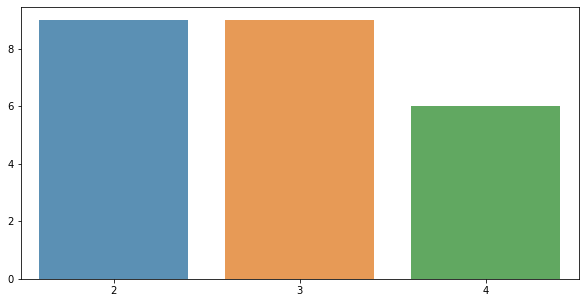

In [24]:
Period_Count =\
df.period.value_counts(sort=True).nlargest(3)
plt.figure(figsize=(10,5))
sns.barplot(Period_Count.index,
Period_Count.values, alpha=0.8)
plt.show()

In [25]:
df9 = df[df['period'] != '2'].copy()
df9['div_rnk'] = df9.mkt_pct.rank(ascending=False)
df9['amt_rnk'] = df9.mkt_amt.rank(ascending=False)
df9_out = df9[colt].sort_values('div_rnk')
df9_out.set_index('name', inplace=True)
df9_tab = pn.widgets.Tabulator(df9_out, layout='fit_data', width=900)
df9_tab

Tabulator(layout='fit_data', value=        shares  ..., width=900)

In [26]:
short_term = (df.period == '4')
df.loc[short_term].head().style.format(format_dict)

,name,shares,unit_cost,dividend,mkt_price,period,cost_amt,mkt_amt,div_amt,cost_pct,mkt_pct,pft_pct,div_rnk,amt_rnk
21,DOHOME,"14,400",20.25,nan,20.60,4,"291,600.00","296,640.00",nan,nan%,nan%,1.73%,nan,15.0
22,PTT,"9,000",38.50,2.0000,38.50,4,"346,500.00","346,500.00","18,000.00",5.19%,5.19%,0.00%,18.0,11.0
23,RJH,"4,500",33.00,2.5000,32.25,4,"148,500.00","145,125.00","11,250.00",7.58%,7.75%,-2.27%,6.0,25.0
24,SCC,900,398.00,9.9999,381.00,4,"358,200.00","342,900.00","8,999.91",2.51%,2.62%,-4.27%,22.0,12.0
25,SIS,"4,500",40.50,1.2000,38.75,4,"182,250.00","174,375.00","5,400.00",2.96%,3.10%,-4.32%,20.0,23.0


In [27]:
data = df.loc[short_term]
names = data['name']
in_p = ", ".join(map(lambda name: "'%s'" % name, names))
in_p

"'DOHOME', 'PTT', 'RJH', 'SCC', 'SIS', 'WHART'"

In [28]:
sql = '''
SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN (%s)'''
sql = sql % in_p
print(sql)

stocks = pd.read_sql(sql, conmy)
stocks.set_index('name',inplace=True)
stocks


SELECT name, min_price AS min, price, max_price AS max
FROM stocks
WHERE name IN ('DOHOME', 'PTT', 'RJH', 'SCC', 'SIS', 'WHART')


,min,price,max
name,,,
DOHOME,15.17,20.58,25.62
PTT,34.00,40.00,42.50
RJH,25.00,32.50,39.00
SCC,367.00,385.00,474.00
SIS,21.20,40.00,48.75
WHART,11.38,12.10,14.08


In [29]:
#stocks.drop('SCC',inplace=True)
#stocks

<AxesSubplot:xlabel='name'>

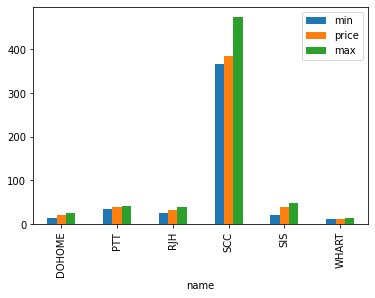

In [30]:
stocks.plot.bar()

In [31]:
#stocks.reset_index('name',inplace=True)
#sns.barplot(x='name', y='price', data=stocks)

### Portfolio cumulative sum by period, name

In [32]:
colw = 'period name shares unit_cost cost_amt mkt_amt cumsum'.split()
df['cumsum'] = df.groupby('period')['mkt_amt'].cumsum()
df[colw].sort_values(by=['period','name'],ascending=[True,True]).style.format(format_dict)

,period,name,shares,unit_cost,cost_amt,mkt_amt,cumsum
0,1,KCE,"11,000",75.50,"830,500.00","643,500.00","643,500.00"
1,1,PTTGC,"12,000",58.75,"705,000.00","606,000.00","1,249,500.00"
2,1,STA,"22,500",33.75,"759,375.00","579,375.00","1,828,875.00"
3,2,CPNCG,"20,000",12.40,"248,000.00","248,000.00","248,000.00"
4,2,DIF,"50,000",14.70,"735,000.00","705,000.00","953,000.00"
5,2,HREIT,"40,100",8.95,"358,895.00","352,880.00","1,305,880.00"
6,2,JASIF,"110,000",10.10,"1,111,000.00","1,188,000.00","2,493,880.00"
7,2,MCS,"50,000",16.70,"835,000.00","730,000.00","3,223,880.00"
8,2,RATCH,"6,000",45.75,"274,500.00","274,500.00","3,498,380.00"
9,2,SCCC,"1,200",171.00,"205,200.00","186,000.00","3,684,380.00"
